In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [116]:
### make a reference trajectory
from math import pi, cos, sin
theta = np.arange(-0.1, 2*pi, 0.1)

traj1 = []
r1 = 0.1
for t in theta:
    traj1.append((r1 * cos(t) - r1, r1 * sin(t)))

traj2 = []
r1 = 0.5
for t in theta:
    traj2.append((r2 * cos(t+pi) + r2, r2 * sin(t+pi)))

ref_traj = np.vstack((traj1, traj2))
t = np.arange(0, 1, 1/128).reshape(128,1)

ref_traj = np.hstack((t, ref_traj))
#x, y = zip(*ref_traj)
#plt.plot(x,y)

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [62]:
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, action_dim, trainable_std=False):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.fc_v = nn.Linear(256, 1)
        
        if trainable_std:
            self.std = nn.Parameter(torch.exp(torch.ones(action_dim) * (-1)))
        else:
            self.std = torch.exp(torch.ones(action_dim) * (-1))
            
    def pi(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc3(x)
        
        dist = torch.distributions.Normal(mean, self.std)
        actions = dist.sample()
        # actions = torch.clip(actions, -1, 1)
        log_probs = dist.log_prob(actions)
        return mean, actions, log_probs

    def get_prob(self, x, a):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc3(x)
        
        dist = torch.distributions.Normal(mean, self.std)
        log_probs = dist.log_prob(a)
        
        entropy = dist.entropy()
        return log_probs, entropy
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        v = self.fc_v(x)
        return v

In [104]:
def train(model, optimizer, hist):
    gamma = 0.99
    tau = 0.95
    eps_clip = 0.2
    entropy_coeff = 0.0
    
    s_lst, a_lst, r_lst, s_prime_lst = [], [], [], []
    l = len(hist)
    param = model.parameters()
    for i in range(l):
        s, a, r, s_prime = hist[i]
        s_lst.append(s)
        a_lst.append(a)
        r_lst.append([r])
        s_prime_lst.append(s_prime)        
        
    
    with torch.no_grad():
        oldvalue_prime = model.v(torch.FloatTensor(s_prime_lst))
        oldvalue = model.v(torch.FloatTensor(s_lst))
        old_states = torch.Tensor(s_lst)
        old_actions = torch.Tensor(a_lst)
        rewards = torch.Tensor(r_lst)
        
        td_targets = rewards + gamma * oldvalue_prime
        advantages = td_targets - oldvalue
    
        #gae = 0
        #advantages = []
        #for i in reversed(range(len(r_lst))):
        #    delta = r_lst[i][0] + gamma * oldvalue_prime[i][0] - oldvalue[i][0]
        #    gae = delta + gamma * tau * gae
        #    advantages.insert(0, [gae])           
        #advantages = torch.tensor(advantages, dtype=torch.float32)
    
        old_probs, _ = model.get_prob(old_states, old_actions)
    
    mse = nn.MSELoss()
    
    n = len(s_lst)
    arr = np.arange(n)
    
    # mini_batch_size = 5
    # n_chunk = int(n//mini_batch_size)
    n_chunk = 4
    mini_batch_size = int(n//n_chunk)
    # if n % mini_batch_size != 0:
    #     n_chunk += 1
    
    approx_kl_divs = []
    actor_loss = []
    critic_loss = []
    entropy_loss = []

    for _ in range(4):
        np.random.shuffle(arr)
        
        for i in range(n_chunk):
            batch_idx = arr[mini_batch_size*i:mini_batch_size*(i+1)]
            b_old_states = old_states[mini_batch_size*i:mini_batch_size*(i+1)]
            b_old_actions = old_actions[mini_batch_size*i:mini_batch_size*(i+1)]
            b_old_probs = old_probs[mini_batch_size*i:mini_batch_size*(i+1)]
            b_targets = td_targets[mini_batch_size*i:mini_batch_size*(i+1)]
            b_advantages = advantages[mini_batch_size*i:mini_batch_size*(i+1)]
            
            new_probs, entropy = model.get_prob(b_old_states, b_old_actions)
            ratios = torch.exp(new_probs - b_old_probs)        
            
            oldvalue = model.v(b_old_states)
            
            surr1 = ratios * b_advantages
            surr2 = torch.clamp(ratios, 1 - eps_clip, 1 + eps_clip) * b_advantages
            
            loss = -torch.min(surr1, surr2).mean() + 0.5 * mse(oldvalue, b_targets).mean() - entropy_coeff * entropy.mean()
            # loss = -torch.min(surr1, surr2) + 0.5 * mse(oldvalue, b_targets) - entropy_coeff * entropy
            
            actor_loss.append(np.mean(-torch.min(surr1, surr2).cpu().detach().numpy()))
            critic_loss.append(np.mean(0.5 * mse(oldvalue, b_targets).cpu().detach().numpy()))
            entropy_loss.append(np.mean(-entropy_coeff * entropy.cpu().detach().numpy()))
            
            with torch.no_grad():
                log_ratio = new_probs - b_old_probs
                approx_kl_div = torch.mean((torch.exp(log_ratio) - 1) - log_ratio).cpu().numpy()
                approx_kl_divs.append(approx_kl_div)
                
            optimizer.zero_grad()
            # loss.mean().backward()
            loss.backward()
            # torch.nn.utils.clip_grad.clip_grad_norm_(param, 0.05)
            optimizer.step()

## with Time Signal

#0 finished | score : -82.01045348998247
#1 finished | score : -83.92663133090443
#2 finished | score : -73.51196920605177
#3 finished | score : -79.49984504221767
#4 finished | score : -75.33628127480225
#5 finished | score : -76.78150821444227
#6 finished | score : -72.97409735785261
#7 finished | score : -70.87323172655476
#8 finished | score : -74.20810393601874
#9 finished | score : -71.82802914312056
#10 finished | score : -66.24908416453363
#11 finished | score : -64.1297719600388
#12 finished | score : -68.70238060006807
#13 finished | score : -60.70784024666423
#14 finished | score : -62.158653986003884
#15 finished | score : -61.06553106166262
#16 finished | score : -68.49293769649883
#17 finished | score : -61.12953334659118
#18 finished | score : -60.46428017939423
#19 finished | score : -65.34254038176101
#20 finished | score : -62.14509986541752
#21 finished | score : -62.897362767445564
#22 finished | score : -63.39493745077774
#23 finished | score : -62.987607586000856


#193 finished | score : -64.02715813777641
#194 finished | score : -58.93800774473272
#195 finished | score : -60.84408938466797
#196 finished | score : -55.042927165223205
#197 finished | score : -59.44936026590855
#198 finished | score : -57.36006386564917
#199 finished | score : -56.48547103725651
#200 finished | score : -55.56998120317095
#201 finished | score : -63.02695824618366
#202 finished | score : -58.27509967057654
#203 finished | score : -54.87215238218086
#204 finished | score : -60.86622661487187
#205 finished | score : -59.11393337410742
#206 finished | score : -60.98795267047358
#207 finished | score : -55.0059298810069
#208 finished | score : -58.18378308965374
#209 finished | score : -56.91735292855477
#210 finished | score : -62.77561416675292
#211 finished | score : -54.404774985329055
#212 finished | score : -55.50203030158816
#213 finished | score : -58.01737230291529
#214 finished | score : -60.029714422902124
#215 finished | score : -55.97317933155873
#216 fini

#383 finished | score : -58.28906770367944
#384 finished | score : -56.90409653105536
#385 finished | score : -60.67335532113097
#386 finished | score : -54.32599415148701
#387 finished | score : -61.274236946707205
#388 finished | score : -59.299489510281326
#389 finished | score : -59.57623596133853
#390 finished | score : -56.65638823541598
#391 finished | score : -55.70537723721155
#392 finished | score : -56.49862823034983
#393 finished | score : -56.847604279988694
#394 finished | score : -56.97010060645319
#395 finished | score : -58.76580507734166
#396 finished | score : -56.527306916742816
#397 finished | score : -55.36445645391255
#398 finished | score : -58.2415260262867
#399 finished | score : -59.64359269796049
#400 finished | score : -58.275685397184375
#401 finished | score : -62.761310788626865
#402 finished | score : -62.49259886481186
#403 finished | score : -60.621019649191894
#404 finished | score : -59.08019842073795
#405 finished | score : -59.791110449574596
#406

#573 finished | score : -56.08452122061153
#574 finished | score : -60.009112987328514
#575 finished | score : -57.14081109981935
#576 finished | score : -59.47043469252105
#577 finished | score : -53.217141138284326
#578 finished | score : -59.8306416319949
#579 finished | score : -61.822089613225685
#580 finished | score : -55.04601387290197
#581 finished | score : -54.21744784654943
#582 finished | score : -60.15471888798915
#583 finished | score : -57.25713984623334
#584 finished | score : -61.26597002417818
#585 finished | score : -63.21405121846383
#586 finished | score : -61.26099215071076
#587 finished | score : -54.79202464540045
#588 finished | score : -57.634665586730485
#589 finished | score : -58.61037850728726
#590 finished | score : -56.94356841318866
#591 finished | score : -65.49419610682214
#592 finished | score : -58.82734333518232
#593 finished | score : -55.57292597363795
#594 finished | score : -57.50176950255187
#595 finished | score : -59.504675195725866
#596 fi

#763 finished | score : -60.60974696175984
#764 finished | score : -60.32097519749234
#765 finished | score : -61.00261781496038
#766 finished | score : -58.890418330224264
#767 finished | score : -66.06814016117207
#768 finished | score : -55.43742851880135
#769 finished | score : -57.63222685326827
#770 finished | score : -58.67788651727564
#771 finished | score : -59.802811636763394
#772 finished | score : -63.43344357029097
#773 finished | score : -59.58121758743347
#774 finished | score : -54.22187579365815
#775 finished | score : -56.5586834202846
#776 finished | score : -53.52860585004846
#777 finished | score : -57.47009651264419
#778 finished | score : -55.795078169386386
#779 finished | score : -56.84505149742699
#780 finished | score : -59.74460006639407
#781 finished | score : -60.5039793958236
#782 finished | score : -60.88717898042933
#783 finished | score : -61.13270589357771
#784 finished | score : -59.80567598892975
#785 finished | score : -62.286776654578254
#786 fini

#953 finished | score : -60.05437945272118
#954 finished | score : -59.2264115189726
#955 finished | score : -58.81577912429079
#956 finished | score : -62.75136563082015
#957 finished | score : -57.24115373268403
#958 finished | score : -62.13432180184055
#959 finished | score : -62.48405164607927
#960 finished | score : -59.58513662840018
#961 finished | score : -57.416898234365505
#962 finished | score : -64.86109838692892
#963 finished | score : -64.19635985635595
#964 finished | score : -53.20294313478558
#965 finished | score : -64.27410355797903
#966 finished | score : -59.344027529140064
#967 finished | score : -61.29433611005312
#968 finished | score : -56.04724322124247
#969 finished | score : -56.528847894842194
#970 finished | score : -58.14630009159335
#971 finished | score : -61.681972250176564
#972 finished | score : -59.45556787072229
#973 finished | score : -59.72868343206677
#974 finished | score : -57.3242993301039
#975 finished | score : -56.31303284883203
#976 fini

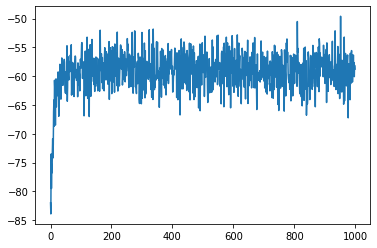

In [117]:
from math import sqrt

torch.manual_seed(0)

obs_dim = 3
action_dim = 2
model = ActorCritic(obs_dim, action_dim)
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)

l = len(ref_traj)
score_hist = []
for rollout in range(1000):
    score = 0
    hist = []
    for i in range(l-1):
        s = ref_traj[i]
        s = torch.FloatTensor(s)
        _, a, _ = model.pi(s)
        s_prime = ref_traj[i+1]
        expected_pos = a.detach().numpy()
        r = -sqrt((s_prime[1] - expected_pos[0])**2 + (s_prime[2] - expected_pos[1])**2)
        score += r
        hist.append((s.tolist(), a.tolist(), r/100, s_prime.tolist()))

    train(model, optimizer, hist)

    score_hist.append(score)
    print(f'#{rollout} finished | score : {score}')
plt.plot(score_hist)

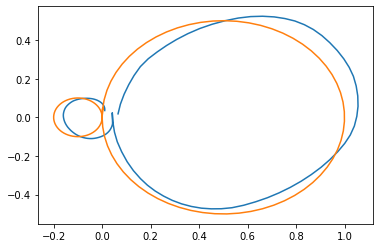

In [128]:
net_out = []
for i in range(l-1):
    s = ref_traj[i]
    s = torch.FloatTensor(s)
    a, _, _ = model.pi(s)
    expected_pos = a.detach().tolist()
    net_out.append((expected_pos[0], expected_pos[1]))

x_t, y_t = zip(*net_out)
plt.plot(x_t,y_t)
t, x, y = zip(*ref_traj)
plt.plot(x,y)

## with Trajectory Generator

In [119]:
def TG(t, a_x, a_y):
    x = a_x * sin(2*pi*t)
    y = a_y / 2 * sin(2*pi*t) * cos(2*pi*t)
    
    return x, y

#0 finished | score : -94.3505236345247
#1 finished | score : -81.77434155395619
#2 finished | score : -85.61078245189778
#3 finished | score : -82.64903626735986
#4 finished | score : -79.18249401893115
#5 finished | score : -67.53256440367346
#6 finished | score : -73.99482050587268
#7 finished | score : -71.91639930961803
#8 finished | score : -70.45490153957475
#9 finished | score : -76.41865740180961
#10 finished | score : -74.28476400269824
#11 finished | score : -65.47049715604479
#12 finished | score : -68.19532336025799
#13 finished | score : -71.33969031082793
#14 finished | score : -72.96663463248082
#15 finished | score : -64.6805811590885
#16 finished | score : -76.24828147904715
#17 finished | score : -67.33856929129837
#18 finished | score : -72.21717762665483
#19 finished | score : -69.38748526223014
#20 finished | score : -72.26115489575851
#21 finished | score : -65.21662194120903
#22 finished | score : -70.3084579382723
#23 finished | score : -71.7807780595167
#24 fi

#194 finished | score : -62.12829340576824
#195 finished | score : -69.85697848018305
#196 finished | score : -72.0581971699952
#197 finished | score : -62.45140462289407
#198 finished | score : -64.86270099867959
#199 finished | score : -65.23872026545692
#200 finished | score : -62.695053742981735
#201 finished | score : -62.51903351897133
#202 finished | score : -69.11732044032705
#203 finished | score : -70.83359742986673
#204 finished | score : -65.70497521302364
#205 finished | score : -65.3566210582103
#206 finished | score : -67.99040153594294
#207 finished | score : -62.959251274628464
#208 finished | score : -69.96307279145466
#209 finished | score : -66.5069184965988
#210 finished | score : -66.2361613642715
#211 finished | score : -62.411304544270294
#212 finished | score : -68.59392804506574
#213 finished | score : -63.82650772241646
#214 finished | score : -67.12948792365572
#215 finished | score : -69.73766791442691
#216 finished | score : -66.74002160220411
#217 finishe

#385 finished | score : -67.83799600847317
#386 finished | score : -64.06291458659805
#387 finished | score : -65.55751072611592
#388 finished | score : -63.248343913187995
#389 finished | score : -57.97880864345918
#390 finished | score : -62.071149386121114
#391 finished | score : -64.52667586101502
#392 finished | score : -73.08159493337003
#393 finished | score : -63.18287277375635
#394 finished | score : -67.28712602221331
#395 finished | score : -64.92716119772051
#396 finished | score : -63.57059490651314
#397 finished | score : -63.228119933275906
#398 finished | score : -63.46702586475295
#399 finished | score : -65.15878142590515
#400 finished | score : -71.41987577556625
#401 finished | score : -68.38659941866298
#402 finished | score : -68.91563461062987
#403 finished | score : -68.38601511733235
#404 finished | score : -65.81021450334893
#405 finished | score : -62.87517009021988
#406 finished | score : -69.07756336710555
#407 finished | score : -66.04244853619544
#408 fin

#576 finished | score : -66.96276038328413
#577 finished | score : -63.79146219968412
#578 finished | score : -65.97486449791523
#579 finished | score : -66.39427074622891
#580 finished | score : -67.48587368529034
#581 finished | score : -66.64524291030823
#582 finished | score : -67.33608343216271
#583 finished | score : -66.28534673378282
#584 finished | score : -71.13872445001759
#585 finished | score : -64.61413626031104
#586 finished | score : -65.8577565975246
#587 finished | score : -66.2201873333345
#588 finished | score : -62.77639007259086
#589 finished | score : -67.09684505368698
#590 finished | score : -64.82931242463573
#591 finished | score : -68.19009396719416
#592 finished | score : -67.09303370457395
#593 finished | score : -61.25113489283732
#594 finished | score : -64.91584008789941
#595 finished | score : -67.16564422033028
#596 finished | score : -69.61537475037345
#597 finished | score : -64.16802839718206
#598 finished | score : -69.30009963273649
#599 finished

#767 finished | score : -69.34479275111309
#768 finished | score : -63.55752304243905
#769 finished | score : -66.50401225255396
#770 finished | score : -72.45339601354935
#771 finished | score : -66.20288168130341
#772 finished | score : -61.56791044382498
#773 finished | score : -69.95110985025556
#774 finished | score : -65.35087719801905
#775 finished | score : -63.75816630260144
#776 finished | score : -65.79458770892012
#777 finished | score : -67.29642213056474
#778 finished | score : -67.11854982848489
#779 finished | score : -67.30295071625062
#780 finished | score : -65.25117797701873
#781 finished | score : -67.86661570495983
#782 finished | score : -65.99482094389492
#783 finished | score : -71.1272326694518
#784 finished | score : -71.59202992370966
#785 finished | score : -69.11519834882986
#786 finished | score : -65.99211475055552
#787 finished | score : -68.00601085650078
#788 finished | score : -67.33024523321728
#789 finished | score : -68.9169218981911
#790 finished

#958 finished | score : -71.27103689529062
#959 finished | score : -62.56387241257179
#960 finished | score : -67.95043033038758
#961 finished | score : -66.9957655210991
#962 finished | score : -68.35996769788422
#963 finished | score : -64.2187939389083
#964 finished | score : -66.07975433957827
#965 finished | score : -64.56297179309453
#966 finished | score : -68.05935477875472
#967 finished | score : -68.96365490033854
#968 finished | score : -62.1398736410731
#969 finished | score : -63.257273831104
#970 finished | score : -59.81482838536626
#971 finished | score : -64.15441925618238
#972 finished | score : -68.4428756697014
#973 finished | score : -67.34235605498915
#974 finished | score : -70.3902265096005
#975 finished | score : -70.35997410313561
#976 finished | score : -60.1542014177637
#977 finished | score : -67.04228071479706
#978 finished | score : -63.09977240149732
#979 finished | score : -63.71604422070176
#980 finished | score : -67.85497729277692
#981 finished | sco

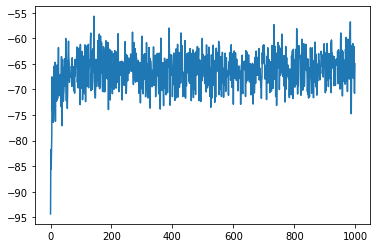

In [125]:
obs_dim = 3
action_dim = 4
model2 = ActorCritic(obs_dim, action_dim)
lr = 0.0001
optimizer2 = optim.Adam(model2.parameters(), lr=lr)

l = len(ref_traj)
score_hist = []
for rollout in range(1000):
    score = 0
    hist = []
    for i in range(l-1):
        s = ref_traj[i]
        s = torch.FloatTensor(s)
        _, a, _ = model2.pi(s)
        a = a.detach().tolist()
        tg_x, tg_y = TG(ref_traj[i][0], a[0], a[1])
        s_prime = ref_traj[i+1]
        expected_pos = [a[2] + tg_x, a[3] + tg_y]
        r = -sqrt((s_prime[1] - expected_pos[0])**2 + (s_prime[2] - expected_pos[1])**2)
        score += r
        hist.append((s.tolist(), a, r/100, s_prime.tolist()))

    train(model2, optimizer2, hist)

    score_hist.append(score)
    print(f'#{rollout} finished | score : {score}')
plt.plot(score_hist)

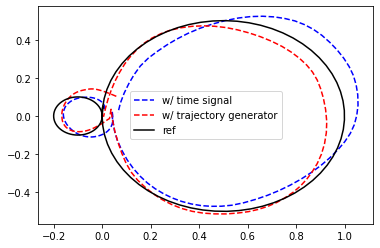

In [133]:
net_out = []
for i in range(l-1):
    s = ref_traj[i]
    s = torch.FloatTensor(s)
    a, _, _ = model2.pi(s)
    a = a.tolist()
    tg_x, tg_y = TG(ref_traj[i][0], a[0], a[1])
    expected_pos = [a[2] + tg_x, a[3] + tg_y]
    net_out.append((expected_pos[0], expected_pos[1]))

plt.plot(x_t, y_t, 'b--')
x, y = zip(*net_out)
plt.plot(x,y, 'r--')
t, x, y = zip(*ref_traj)
plt.plot(x,y, 'k')
plt.legend(['w/ time signal', 'w/ trajectory generator', 'ref'])